In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qutip import *

## Parameters

In [3]:
N = 2 #cavity states
Nvib1 = 2 #qubit 1 vibrational states
Nvib2 = Nvib1 #qubit 2 vibrational states
pi =  np.pi
w1 = 0.8365513706206968 #electronic excitation enegy of HF (from HF_excitation_energy.ipynb)
w2 = w1 #both qubits are HF
wv1 = 0.018335911729858174 #ground state vibration frequency of HF (from HF_DFT_potential_energy_surface.ipynb)
wv2 = wv1 #both qubits are the HF
S = 1.0 #63.36098382523666 #Huang-Rhys factor of HF (from HF_Huang_Rhys.ipynb)
wc = 5 * pi

g1 = 0.01 * 2 * pi
g2 = g1

tlist = np.linspace(0, 150, 500)

width = 0.5


# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*pi)/(4 * g2)


### Operators, Hamiltonian and initial state 

dipole operator for the atom has the form

-6.43777131e-01 atomic units, the excited state has a dipole moment of 4.20099337e-01 atomic units, and the transition dipole moment is -7.60294804e-01 (all along z) as computed at the FCI/cc-pVTZ level of theory.

Next block will build the $\lambda \cdot \mu$ matrices for each system (consistent with their g values) for the model that includes 
the full bilinear coupling and dipole self energy

In [4]:
# lamda value s.t. the original mu_12 * lam = g1 -> 0.026919208248238624
lam = 0.026919208248238624 

# scaling of dipole moment for system 2 s.t. original g2 is scaled appropriately -> 1.2247448713915894
tdm_fac = np.sqrt(3/2)

$\hat\mu_1$ is the dipole operator for HF and d_1 and d_2 are the scaled dipole operators for qubit 1 and 2 respectively.

In [5]:
#dipole moments in e a0, from HF_CASCI_TDM.ipynb
mu_1 = -0.7275466054308762 * sigmap() * sigmam() #ground dipole moment
mu_1 += 0.7751862316027126 * sigmam() * sigmap() #excited dipole moment
mu_1 += 0.8142093557243336 * (sigmap() + sigmam()) #transition dipole moment


d_1 = lam * mu_1
d_2 = tdm_fac * d_1

# define g1 and g2 in terms of sqrt(w/2) * d[0,1] terms
_g1 = np.abs(np.sqrt(w1/2) * d_1[0,1])
_g2 = np.abs(np.sqrt(w2/2) * d_2[0,1])

# resonant SQRT iSWAP gate 
### JJF Note: These have been recomputed using the actual coupling strengths for qubit 1 and 2
### based on $\lambda$ and $\mu_{01}$/
T0_1 = 20
T_gate_1 = (1*pi)/(4 * _g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*pi)/(4 * _g2)

In [6]:
d_1

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-0.01958498  0.02191787]
 [ 0.02191787  0.0208674 ]]

In [7]:
d_2

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-0.0239866   0.0268438 ]
 [ 0.0268438   0.02555724]]

## Basis Order of Operators

- cav = fock states of the cavity = variable "N" in code
- q1 = fock states of qubit 1 = 2
- q2 = fock states of qubit 2 = 2
- Nvib1 = qubit 1 vibrational modes
- Nvib2 = qubit 2 vibrational modes

The basis order for all operators follows the order:

$$ \hat{H} = basis_{cav} \otimes basis_{q1} \otimes basis_{q2} \otimes basis_{Nvib1} \otimes basis_{Nvib2} $$

The cavity operator $\hat{a}$, qubit 1 operator $\sigma^{-}_1$, qubit 2 operator $\sigma^{-}_2$, qubit 1 vibrational operator $\hat{b}_1$, and qubit 2 vibrational operator $\hat{b}_2$ are by using their respective basis' annihilation matrix and the identity for the other bases.

The $\sigma_z$ operators for qubit 1 and 2, $\sigma_{z1}$ and $\sigma_{z2}$ respectively, were created by

$$ \sigma_{z1} = \mathcal{I}_{cav} \otimes \sigma_z \otimes \mathcal{I}_2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2} $$

$$ \sigma_{z1} = \mathcal{I}_{cav} \otimes \mathcal{I}_2 \otimes \sigma_z \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2} $$

The dipole operators of qubit 1 and 2, $\hat{d}_1$ and $\hat{d}_2$, are created by:

$$ \hat{d}_1 = \mathcal{I}_{cav} \otimes \lambda \hat\mu_1 \otimes \mathcal{I}_2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2} $$
$$ \hat{d}_2 = \mathcal{I}_{cav} \otimes \mathcal{I}_2 \otimes \sqrt{\frac{3}{2}} \lambda \hat\mu_1 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2} $$

The dipole self energy operator $\hat{d}_{se}$ was created by:
$$ \hat{d}_{se} = \mathcal{I}_{cav} \otimes \frac{1}{2} (\lambda \hat\mu_1 \otimes \mathcal{I}_2 + \mathcal{I}_2 \otimes \sqrt{\frac{3}{2}} \lambda \hat\mu_1)^2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2} $$

**JJF Note**
The way I might naturally think of the dipole self energy operator in the composite space is as follows:

1. Define a total $\hat{d}$ operator as

\begin{align}
\hat{d} &= \hat{d}_1 + \hat{d}_2 \\
        &=  \mathcal{I}_{cav} \otimes \lambda \hat\mu_1 \otimes \mathcal{I}_2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2} + \mathcal{I}_{cav} \otimes \mathcal{I}_2 \otimes \sqrt{\frac{3}{2}} \lambda \hat\mu_1 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2}
\end{align}

2. Define the dipole self energy operator as 

\begin{align}
\hat{H}_{\rm dse} &= \frac{1}{2} \hat{d} ^2 \\
                  &= (\mathcal{I}_{cav} \otimes \lambda \hat\mu_1 \otimes \mathcal{I}_2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2})^2 \\
                  & + (\mathcal{I}_{cav} \otimes \mathcal{I}_2 \otimes \sqrt{\frac{3}{2}} \lambda \hat\mu_1 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2})^2 \\
                  & + (\mathcal{I}_{cav} \otimes \lambda \hat\mu_1 \otimes \mathcal{I}_2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2}) @ (\mathcal{I}_{cav} \otimes \mathcal{I}_2 \otimes \sqrt{\frac{3}{2}} \lambda \hat\mu_1 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2}) \\
                  & + (\mathcal{I}_{cav} \otimes \mathcal{I}_2 \otimes \sqrt{\frac{3}{2}} \lambda \hat\mu_1 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2}) @ (\mathcal{I}_{cav} \otimes \lambda \hat\mu_1 \otimes \mathcal{I}_2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2})
\end{align}

Please double check that building the operators in this way matches the way you approached it by building both ways and using `np.allclose(dse_approach_1, dse_approach_2)`

**NOTE:** both approaches are equal

**Also** Make sure the matrix multiplications are performed using `@`, the `*` can perform element-by-element multiplication with some types of matrices (like numpy arrays).  This applies to the squared terms in the DSE as well:

**NOTE:** `*` and `@` perform the same function in QuTip

$$ (\mathcal{I}_{cav} \otimes \lambda \hat\mu_1 \otimes \mathcal{I}_2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2})^2 = (\mathcal{I}_{cav} \otimes \lambda \hat\mu_1 \otimes \mathcal{I}_2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2}) @ (\mathcal{I}_{cav} \otimes \lambda \hat\mu_1 \otimes \mathcal{I}_2 \otimes \mathcal{I}_{Nvib1} \otimes \mathcal{I}_{Nvib2}) $$

In [8]:
#order for operators cavity basis, qubit1 basis, qubit2 basis, vib1 basis, vib2 basis
# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2), qeye(Nvib1), qeye(Nvib2))
b1 = tensor(qeye(N), qeye(2), qeye(2), destroy(Nvib1), qeye(Nvib2))
b2 = tensor(qeye(N), qeye(2), qeye(2), qeye(Nvib1), destroy(Nvib2))
n = a.dag() * a

# operators for qubit 1
sm1 = tensor(qeye(N), destroy(2), qeye(2), qeye(Nvib1), qeye(Nvib2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2), qeye(Nvib1), qeye(Nvib2))
n1 = sm1.dag() * sm1

# oeprators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2), qeye(Nvib1), qeye(Nvib2))
sz2 = tensor(qeye(N), qeye(2), sigmaz(), qeye(Nvib1), qeye(Nvib2))
n2 = sm2.dag() * sm2

# dipole self energy for qubit 1 and 2
_d1 = tensor(d_1, qeye(2))
_d2 = tensor(qeye(2), d_2)
# d1 = tensor(qeye(N), _d1)
# d2 = tensor(qeye(N), _d2)
d1 = tensor(qeye(N), _d1, qeye(Nvib1), qeye(Nvib2))
d2 = tensor(qeye(N), _d2, qeye(Nvib1), qeye(Nvib2))

### JJF Note - replace this * with @ operator -> _dse = 1/2 * (_d1 + _d2) @ (_d1 + _d2)
_dse = 1/2 * (_d1 + _d2) * (_d1 + _d2)
#dse = tensor(qeye(N), _dse)
dse = tensor(qeye(N), _dse, qeye(Nvib1), qeye(Nvib2))

d = d1 + d2

dse_new = 0.5 * d **2

dse_new1 = d1 **2 + d2 **2 + d1 * d2 + d2 * d1

In [9]:
dse

Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.00154973 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00154973 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00154973 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00167811 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00167811 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00167811]]

In [10]:
dse_new

Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.00154973 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00154973 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00154973 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00167811 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00167811 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00167811]]

In [11]:
dse_new1

Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.00309947 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00309947 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00309947 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00335623 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00335623 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00335623]]

In [12]:
print(np.allclose(dse.full(), dse_new.full()))

True


In [13]:
### JJF Comment - this looks like what I was describing in the markdown block above; it does not
###               match the DSE operator above, so this needs some troubleshooting.
dse_1 = tensor(qeye(N), (1/2 * _d1 * _d1), qeye(Nvib1), qeye(Nvib2))
dse_2 = tensor(qeye(N), (1/2 * _d2 * _d2), qeye(Nvib1), qeye(Nvib2))
dse_12 = tensor(qeye(N), (1/2 * _d1 * _d2 + 1/2 * _d2 * _d1), qeye(Nvib1), qeye(Nvib2))
dse_12

Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.00046978 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00046978 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00046978 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00053331 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00053331 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00053331]]

The Hamiltonian is created by:
$$ \hat{H}_c = \hbar \omega_c \hat{a}^\dagger \hat{a}  $$
$$ \hat{H}_1 = - \hbar \omega_1 \frac{1}{2} \sigma_{z1} $$
$$ \hat{H}_2 = - \hbar \omega_2 \frac{1}{2} \sigma_{z2} $$
$$ \hat{H}_{bprod1} = \hbar \omega_{v1} \hat{b}_1^\dagger \hat{b}_1 $$
$$ \hat{H}_{bprod2} = \hbar \omega{v2} \hat{b}_2^\dagger \hat{b}_2 $$
$$ \hat{H}_{b1} = - \hbar \omega_{v1} S (\hat{b}_1^\dagger + \hat{b}_1) \sigma^+_1 \sigma^-_1 $$
$$ \hat{H}_{b2} = - \hbar \omega_{v2} S (\hat{b}_2^\dagger + \hat{b}_2) \sigma^+_2 \sigma^-_2 $$

For simple coupling

$$ \hat{H}_{c1} = g_1 (\hat{a}^\dagger \sigma^-_1 + \hat{a} \sigma^+_1) $$
$$ \hat{H}_{c2} = g_2 (\hat{a}^\dagger \sigma^-_2 + \hat{a} \sigma^+_2) $$

$$ \hat{H}_{simple} = \hat{H}_c + \hat{H}_1 + \hat{H}_2 + \hat{H}_{c1} + \hat{H}_{c2} + \hat{H}_{bprod1} + \hat{H}_{bprod2} + \hat{H}_{b1} + \hat{H}_{b2} $$

For notsimple coupling

$$\hat{H}_{c1} = \sqrt\frac{\omega_1}{2} (\hat{a}^\dagger \hat{d}_1 + \hat{a} \hat{d}_1) $$
$$\hat{H}_{c2} = \sqrt\frac{\omega_2}{2} (\hat{a}^\dagger \hat{d}_2 + \hat{a} \hat{d}_2) $$

$$ \hat{H}_{notsimple} = \hat{H}_c + \hat{H}_1 + \hat{H}_2 + \hat{H}_{c1} + \hat{H}_{c2} + \hat{H}_{bprod1} + \hat{H}_{bprod2} + \hat{H}_{b1} + \hat{H}_{b2} + \hat{d}_{se} $$

**NOTE**: in the equation of Hc, H1, H2, brpod1, and bprod2, the omega is left out to be a time dependent variable later on


**JJF Note** I think you want to include the $\omega$ factors in Hc, H1, H2, bprod1, bprod2, the time-dependent terms just shift the $\omega$ values from some initial value to be in resonance with Hc.

In [14]:
# Hamiltonian using QuTiP
coupling="notsimple"

Hc = a.dag() * a
H1 = - 0.5 * sz1
H2 = - 0.5 * sz2
bprod1 = wv1 * b1.dag() * b1
bprod2 = wv2 * b2.dag() * b2

#Hb1 = - wv1 * S * (b1.dag() + b1) * sm1.dag() * sm1
#Hb2 = - wv2 * S * (b2.dag() + b2) * sm2.dag() * sm2
Hb1 = - wv1 * S * (b1.dag() + b1) * 0.5 * sz1
Hb2 = - wv2 * S * (b2.dag() + b2) * 0.5 * sz2

if coupling=="simple":
    Hc1 = _g1 * (a.dag() * sm1 + a * sm1.dag())
    Hc2 = _g2 * (a.dag() * sm2 + a * sm2.dag())
    Hi = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2 #Hi
    H = Hi + bprod1 + Hb1 + bprod2 + Hb2

else:
    Hc1 = np.sqrt(w1/2) * (a.dag() * d1 + a * d1)
    Hc2 = np.sqrt(w2/2) * (a.dag() * d2 + a * d2)
    Hi = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2 + dse
    H = Hi + bprod1 + Hb1 + bprod2 + Hb2

In [15]:
H

Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-8.35001638e-01 -9.16795586e-03 -9.16795586e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.16795586e-03 -8.16665726e-01  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.16795586e-03  0.00000000e+00 -8.16665726e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.65645287e+01
   0.00000000e+00  9.16795586e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   1.65645287e+01  9.16795586e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.16795586e-03
   9.16795586e-03  1.65828646e+01]]

In [16]:
# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N,0),basis(2,1),basis(2,0),basis(Nvib1,0),basis(Nvib2,0))
psi0

Quantum object: dims=[[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape=(32, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

# Ideal two-qubit iSWAP gate

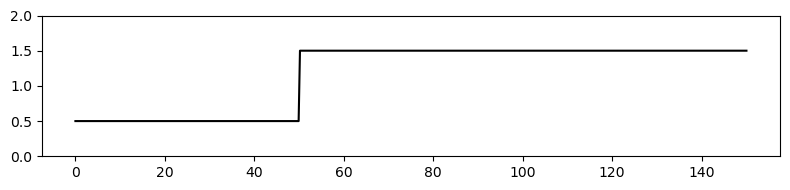

In [17]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, 0.0, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

In [18]:
def wc_t(t, args=None):
    return wc

def w1_t(t, args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t, args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)

def wv1_t(t, args=None):
    return wv1

def wv2_t(t, args=None):
    return wv2

#H_t_orig =  [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2+Hb1+Hb2+bprod1+bprod2]
#H_t_new =   [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hb1, Hb2, bprod1, bprod2, H1+H2+Hc+Hc1+Hc2+Hb1+Hb2+bprod1+bprod2+dse]
H_t_orig =  [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2+Hb1+Hb2+bprod1+bprod2]
H_t_new =   [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2+Hb1+Hb2+bprod1+bprod2+dse]
#H_t_new =   [[Hc, wc_t], [H1, w1_t], [H2, w2_t], [Hb1, wv1_t], [Hb2, wv2_t], [bprod1, wv1_t], [bprod2, wv2_t], H1+H2+Hc+Hc1+bprod1+bprod2+Hb1+Hb2+Hc2+dse]
#H_t_orig =  [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]
#H_t_new =   [[Hc, wc_t], [H1, w1_t], [H2, w2_t], H1+H2+Hc+Hc1+Hc2+dse]

### Evolve the system

In [19]:
res = mesolve(H_t_new, psi0, tlist, [], e_ops=[])

### Plot the results

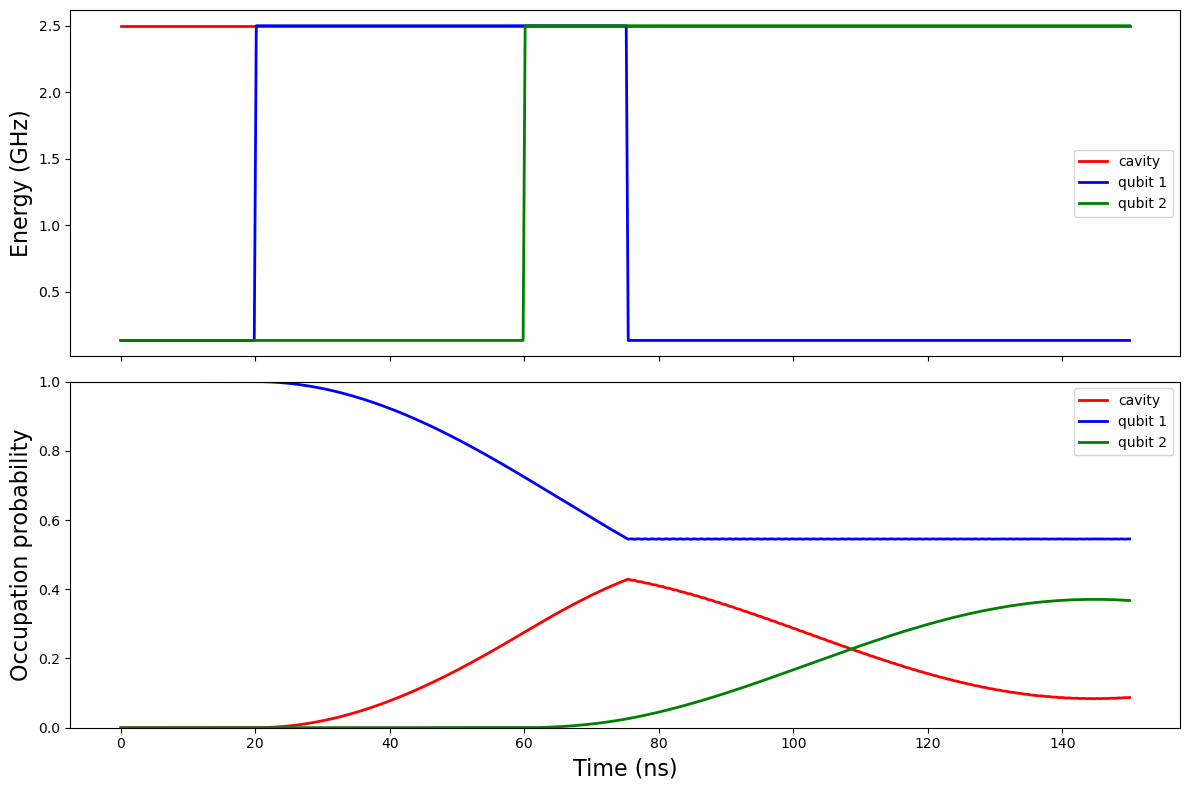

In [20]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
#axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16) #energy is in Hartrees, so the (2pi)^-1 conversion factor does not give giga hertz
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)
#axes[1].set_xlim(60,100)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Inspect the final state

In [ ]:
# extract the final state from the result of the simulation
rho_final = res.states[-1]

In [ ]:
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1,2])
rho_qubits

In [ ]:

# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
from qutip.core.gates import *
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal

### Fidelity and concurrence

In [ ]:
fidelity(rho_qubits, rho_qubits_ideal)

In [ ]:
concurrence(rho_qubits)

# Dissipative two-qubit iSWAP gate

### Define collapse operators that describe dissipation



In [ ]:
kappa = 0.0001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [np.sqrt(kappa) * a, np.sqrt(gamma1) * sm1, np.sqrt(gamma2) * sm2]

### Evolve the system

In [ ]:
res = mesolve(H_t_new, psi0, tlist, c_ops, [])

### Plot the results

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()
fig

### Fidelity and concurrence

In [ ]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [ ]:
fidelity(rho_qubits, rho_qubits_ideal)

In [ ]:
concurrence(rho_qubits)

# Two-qubit iSWAP gate: Finite pulse rise time

In [ ]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t, with finite rise time defined
    by the parameter width.
    """
    return w1 + (w2 - w1) / (1 + np.exp(-(t-t0)/width))


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, width, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

### Evolve the system

In [ ]:
res = mesolve(H_t_new, psi0, tlist, [], [])

### Plot the results

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()
fig

### Fidelity and concurrence

In [ ]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [ ]:
fidelity(rho_qubits, rho_qubits_ideal)

In [ ]:
concurrence(rho_qubits)

# Two-qubit iSWAP gate: Finite rise time with overshoot

In [ ]:
from scipy.special import sici

def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t, with finite rise time and 
    and overshoot defined by the parameter width.
    """

    return w1 + (w2-w1) * (0.5 + sici((t-t0)/width)[0]/(pi))


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, width, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

### Evolve the system

In [ ]:
res = mesolve(H_t_new, psi0, tlist, [], [])

### Plot the results

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()
fig

### Fidelity and concurrence

In [ ]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [ ]:
fidelity(rho_qubits, rho_qubits_ideal)

In [ ]:
concurrence(rho_qubits)

# Two-qubit iSWAP gate: Finite pulse rise time and dissipation

In [ ]:
# increase the pulse rise time a bit
width = 0.6

# high-Q resonator but dissipative qubits
kappa  = 0.00001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [np.sqrt(kappa) * a, np.sqrt(gamma1) * sm1, np.sqrt(gamma2) * sm2]

### Evolve the system

In [ ]:
res = mesolve(H_t_new, psi0, tlist, c_ops, [])

### Plot results

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()
fig

### Fidelity and concurrence

In [ ]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [ ]:
fidelity(rho_qubits, rho_qubits_ideal)

In [ ]:
concurrence(rho_qubits)

# Two-qubit iSWAP gate: Using tunable resonator and fixed-frequency qubits

In [ ]:
# reduce the rise time
width = 0.25

def wc_t(t, args=None):
    return wc - step_t(0.0, wc-w1, T0_1, width, t) + step_t(0.0, wc-w1, T0_1+T_gate_1, width, t) \
              - step_t(0.0, wc-w2, T0_2, width, t) + step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)

H_t = [[Hc, wc_t], H1 * w1 + H2 * w2 + Hc1+Hc2]

### Evolve the system

In [ ]:
res = mesolve(H_t, psi0, tlist, c_ops, [])

### Plot the results

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()
fig

### Fidelity and concurrence

In [ ]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [ ]:
fidelity(rho_qubits, rho_qubits_ideal)

In [ ]:
concurrence(rho_qubits)

### Software versions

In [ ]:
from qutip.ipynbtools import version_table

version_table()